In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import pi, cos, sin, erfc
plot_prefix = "Cholera_plot%d" % (int(10000.*np.random.uniform()))
global nyears_,beta_t_

plt.ion()

In [2]:
#def _(nyears = input_box(default=30, label = 'Number of years, $n_{years}$'),
#      season = input_box(default=1., label = 'Seasonal variability, $c$'),
#      climate = input_box(default=1.5, label = 'Climatic variability, $b$'),
#      show_season=checkbox(default=True,label = "Show seasonal transmission"),
#      show_climate=checkbox(default=True,label = "Show climatic transmission")):

def plot_transmission(nyears = 3,season = 1.,climate=1.5,verbose=False):
    global nyears_,beta_t_
    # We actually calculate in months... 
    nyears_=nyears
    nmonths=12*nyears
    
    # Temporally varying transmission rate
    beta_season=[1.+season*q*(0.1e1-cos(pi*q/0.3e1))/0.8e1 for q in np.arange(1,13)]
    beta_season.reverse()
    #beta_season= [1.+q*(0.1e1-cos(fpi*q/0.3e1))/0.2e1 for q in np.arange(1,13)]
    for i in range(12):
        beta_season[i]=beta_season[i]/beta_season[-1]

    #b0=10.
    climate=max(climate,0.)
    beta_long_term=[q for q in np.linspace(1.5,climate,round(nmonths/2))]
    beta_long_term.extend([q for q in np.linspace(climate,1.5,round(nmonths/2))])
    beta_t=[beta_long_term[i]*beta_season[i % 11] for i in range(nmonths)]
    beta_t_=beta_t

    if verbose:
        print('beta_season = ',beta_season)
        print('beta_long_term = ',beta_long_term)
        print('beta_t = ',beta_t)
        
    # create figure and subpolts
    fig=plt.figure()  #figsize=(20,12))
    # plot seasonal variation in transmission
    ax1=fig.add_subplot(311)
    ax1.plot(np.arange(1,13),beta_season,'r-',label='Seasonal Trans. rate, $\\beta_{season}$')
    #ax1.set_xlabel(r'Months')
    ax1.set_ylabel(r'$\beta_{season}$')
    
    ax2=fig.add_subplot(312)
    ax2.plot(beta_long_term,'b-',label='Climatic Trans. rate,$\\beta_{climate}$')
    #ax2.set_xlabel(r'Months')
    ax2.set_ylabel(r'$\beta_{climate}$')

    ax3=fig.add_subplot(313)
    ax3.plot(range(nmonths),beta_t,'k-',label='Total Trans. rate, $\\beta_t$')
    ax3.set_xlabel(r'Months')
    ax3.set_ylabel(r'$\beta_{t}$')
    #show(trans_plot,gridlines=True)

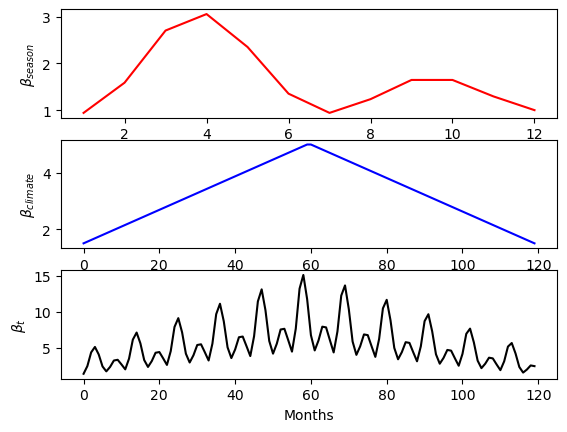

In [3]:
plot_transmission(nyears=10,climate=5)

In [4]:
#def _(Nint = input_box(default=200000, label = 'Population, $N$'),
#      alpha = input_box(default=.57, label='$\\alpha$'),
#      gamma_ = input_box(default=1., label='$\gamma$'),
#      epsilon = slider(0.,1.,0.025,0.,label='Noise'),
#      #epsilon = slider(0.,1.,0.025,0.995,label='Noise'),
#      Iinit_frac = input_box(default=.0001, label='Init. fraction infected'),
#      asymptom = input_box(default=25, label='Asymptomatic ratio, $A$'),
#      t_immunity = input_box(default=12, label='$t_{immunity}$ (mos.)'),
#      frac_vacc = slider(0.,1.,0.025,0.,label='$f_{vaccinated}$'),
#      show_legend=checkbox(default=True,label = "Show legends"),
#      show_immunity=checkbox(default=True,label = "Show immunity")):
    
def plot_caseload(Nint=200000,alpha=.57,gamma_=1.,epsilon = 0.,Iinit_frac=.0001,
                  asymptom=25,t_immunity=12,frac_vacc=0.,
                  show_legend=True,show_immunity=True):
    global nyears_,beta_t_
    nyears=nyears_
    beta_t=beta_t_
    # We actually calculate in months... 
    nmonths=12*nyears
    # We want population as a float
    N=float(Nint)
    
    # Noise
    eps_t=1.+np.random.uniform(low=-epsilon, high=epsilon, size=nmonths)
    #eps_t=1.-epsilon*2.*epsilon*np.random.uniform(low=0.0, high=1.0, size=nmonths)


    #  kappa contains the fractional loss of immunity
    #t_immunity=12 # Period over which immunity declines (in months)
    #kappa=[asymptom*q for q in np.linspace(1.,0.,t_immunity)]
    kappa=[asymptom*0.5*(erfc(q)+0.) for q in np.linspace(-2.,2.,t_immunity)]

    #  Create arrays to hold population categories
    S=[0. for i in range(nmonths)]
    I=[0. for i in range(nmonths+1)]
    R=[0. for i in range(nmonths)]
    years=[q/12. for q in np.arange(nmonths)]

    #  Initial conditions
    I[0]=Iinit_frac*N  #  Initial infecteds
    S[0]=(1.-frac_vacc)*(N-I[0])  #  Initial susceptibles
    R[0]=0.  # Initial resistants

    for t in range(1,nmonths):
    #for t in range(0,nmonths):
        # Calculate the corresponding months
        t_past=[q for q in range(t-t_immunity,t-1) if q>0]
        #kappa_I=[I[tt]*kappa[t-tt] for tt in t_past]
        #print t,t_past,[t-tt-1 for tt in t_past]
        sum_kappa_I=sum([I[tt]*kappa[t-tt-1] for tt in t_past])
        S[t]=(1.-frac_vacc)*(N-sum_kappa_I)
        #S[t]=N-sum_kappa_I
        R[t]=N-S[t]
        I[t]=beta_t[t]*I[t-1]**alpha*(S[t]/N)**gamma_*eps_t[t]
        #print t,sum_kappa_I

    #==============================================================
    #  Use pyplot to create a plot with dual y axes -- code modified from http://ask.sagemath.org/question/1000/two-y-axes
    #
    fig2 = plt.figure()
    # Create the first Y-axis on the left by default and
    # plot the first curve associated to the left Y-axis
    ax3 = fig2.add_subplot(111)
    ln3 = ax3.plot(years,I[0:-1], '-', color='red',label='Infected, $I(t)$')
    ax3.set_ylabel('# Individuals', color='black')
    #ax1.set_ylabel(ylabel='\# Individuals', color='black')
    #ax1.set_ylabel(ylabel='\# Individuals', color='red')

    # Paint the tick labels on the left Y-axis in red 
    # to match the color of a curve
    for tl in ax3.get_yticklabels():
        tl.set_color('red')

    # Create the second Y-axis on the right and
    # plot the second curve associated to the right Y-axis
    ax4 = ax3.twinx()
    ln4 = ax4.plot(years,S, '-', color='blue',label='Susceptible, $S(t)$')
    ax4.set_ylim([0,N])
    #ax2.set_ylabel(ylabel='\# Individuals', color='blue')

    # Paint the tick labels on the left Y-axis in blue 
    # to match the color of a curve
    for tl in ax4.get_yticklabels():
        tl.set_color('blue')

    # Create the vertical and horizontal grid lines
    ax3.xaxis.grid(color='grey', linestyle='--', linewidth=0.5)
    ax3.yaxis.grid(color='grey', linestyle='--', linewidth=0.5)
    #ax3.legend(handles=[ln3,ln4])
    ax3.legend(loc=(0.0625,0.75))
    ax4.legend(loc=(0.65,0.75))
    #ax4.legend(loc=2)
    
    # Set range in time
    plt.xlim([0.,nyears])
    plt.xlabel('Year')
    #if show_legend is True:
     #   # Create a combined legend
     #   lns=ln1+ln2
     #   labs=[l.get_label() for l in lns]
     #   ax3.legend(lns, labs, loc=0)

    # Save the figure (to see it in Sage)
    #plt.savefig(plot_prefix+'_comb.png')
    #fig.show()

    #show(I_plot+S_plot+R_plot)
    fig3 = plt.figure()
    ax5 = fig3.add_subplot(111)
    ax5.plot(kappa,'-',label='Immunity after $i$ mos., $\kappa_{i}$')
    ax5.set_xlabel(r'Months')
    ax5.set_ylabel(r'$\kappa_{i}$')
        #show(imm_plot,gridlines=True)
    # Some textual output
    print('Total number of cholera cases =',sum(I))
    print('Average monthly cholera cases =',sum(I)/len(I)) #mean(I))
    print('Average fraction of population that is susceptible =',sum(S)/(len(S)*N)) #mean(S)/N)
    #print('Average transmission rate =',mean([beta_t))
    print('Average transmission rate =',np.mean([beta_t[t]*eps_t[t] for t in range(1,nmonths)]))

<>:111: SyntaxWarning: invalid escape sequence '\k'
<>:111: SyntaxWarning: invalid escape sequence '\k'
/tmp/ipykernel_182324/744422039.py:111: SyntaxWarning: invalid escape sequence '\k'
  ax5.plot(kappa,'-',label='Immunity after $i$ mos., $\kappa_{i}$')


Total number of cholera cases = 6510.862912454572
Average monthly cholera cases = 53.80878440045101
Average fraction of population that is susceptible = 0.9664155346228338
Average transmission rate = 5.5859396600115625


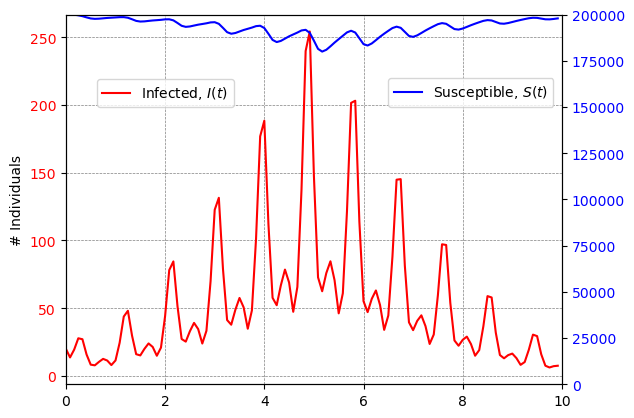

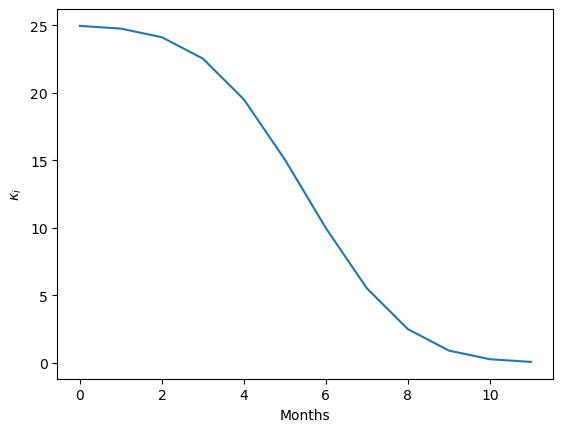

In [5]:
plot_caseload()